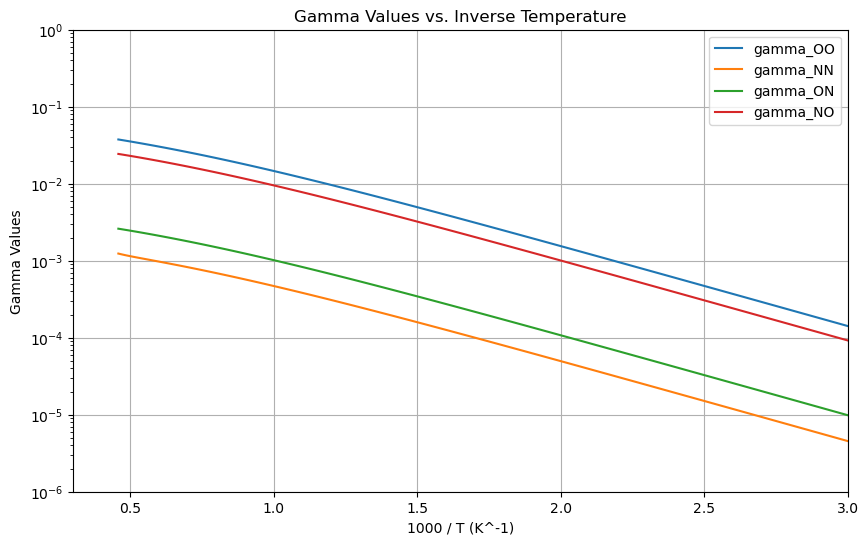

In [7]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd

def para_cata_project(ptot):
    # Constants
    kB = 1.380649e-23  # Boltzmann constant (m^2 kg)/(s^2 K)
    Na = 6.02e+23  # Avogadro constant
    M_O = 16.0   # O's relative atomic mass 
    M_N = 14.0  # N's relative atomic mass
    h = 6.62607015e-34  # Planck constant

    # Inputs
    end_number = 100

    # Pre-allocation
    res = []
    j = 7  # the location of postprocessing dataset

    # Parameters
    p = ptot  # total pressure Pa

    C0 = 10 / 11 * ptot  # O's mole fraction
    CN = 1 / 11  * ptot # N's mole fraction


    

    s_O = 0.05  # sticking coefficient of species O
    s_N = 0.015  # assuming similar sticking coefficient for species N

    cA = 3.5  # for thermal desorption

    nsite = 5e+18  # site number, /m^2

    AA = 0.8
    E_OH = 2.5e+3
    



    P_erOO = 0.1
    P_erNN = 0.1
    P_erON = 0.1
    P_erNO = 0.1

    Q_erOO = 2.0e+4 / Na  # J/molecule
    Q_erNN = 2.0e+4 / Na
    Q_erNO = 2.0e+4 / Na
    Q_erON = 2.0e+4 / Na

    delta = 5.0e-10  # mean distance between sites

    Qa_O = 4.998e+5 / Na  # J/molecule
    Qa_N = 5.308e+5 / Na

    D_OO = 4.980e+5 / Na
    D_NN = 9.413e+5 / Na
    D_NO = 6.251e+5 / Na  

    Em_O = 1.591e+5 / Na
    Em_N = 2.362e+5 / Na

    Q_lhOO = max(Em_O, 2.0 * Qa_O - D_OO)
    Q_lhNN = max(Em_N, 2.0 * Qa_N - D_NN)
    Q_lhNO = Qa_O + Qa_N - D_NO
    
    mass_O = M_O / 1000 / Na
    mass_N = M_N / 1000 / Na

    # Initialization
    L = 0.5 * np.ones(5)
    # Initialize a dictionary to store the results
    res_dict = {
        "theta_O": [],
        "theta_N": [],
        "T": [],
        "x": [],
        "gamma_OO": [],
        "gamma_NN": [],
        "gamma_ON": [],
        "gamma_NO": []
    }

    # Main Loop
    for i in range(end_number):
        T = 200 + i * 20  # input wall temperature
        x = 1000 / T # invT

        # partial pressure
        p_O = p * C0  
        p_N = p * CN

        # Flux of hitting surface
        n_O = p_O / (np.sqrt(2 * np.pi * mass_O * kB * T))  
        n_N = p_N / (np.sqrt(2 * np.pi * mass_N * kB * T))

        # ER
        gamma_star_OO = P_erOO * np.exp(-Q_erOO / (kB * T))
        gamma_star_NN = P_erNN * np.exp(-Q_erNN / (kB * T))  # Assuming similar values for N
        gamma_star_ON = P_erON * np.exp(-Q_erON / (kB * T))  # Assuming similar values for ON
        gamma_star_NO = P_erNO * np.exp(-Q_erNO / (kB * T))  # Assuming similar values for NO

        # LH
        v_O = (cA / delta) * np.sqrt(np.pi * kB * T / (2 * mass_O)) # it's nju_O in UDF
        v_N = (cA / delta) * np.sqrt(np.pi * kB * T / (2 * mass_N))

        # Des
       
 
        #OH
        theta_OH = AA * (1.0 - np.exp(-E_OH / Na / T))

        # Reaction Functions

        omega_ad_O = lambda theta_O, theta_N: s_O * (1 - theta_O - theta_N - theta_OH) * n_O
        omega_ad_N = lambda theta_O, theta_N: s_N * (1 - theta_O - theta_N - theta_OH) * n_N


        omega_ER_OO = lambda theta_O:                           1 * gamma_star_OO * theta_O * n_O
        omega_ER_NN = lambda theta_N:                           1 * gamma_star_NN * theta_N * n_N
        omega_ER_ON = lambda theta_N:                           1 * gamma_star_ON * theta_N * n_O
        omega_ER_NO = lambda theta_O:                           1 * gamma_star_NO * theta_O * n_N

        omega_LH_OO = lambda theta_O:                           2.0 * v_O * nsite * theta_O**2 * np.exp(-Q_lhOO / (kB * T))
        omega_LH_NN = lambda theta_N:                           2.0 * v_N * nsite * theta_N**2 * np.exp(-Q_lhNN / (kB * T))
        omega_LH_NO = lambda theta_O, theta_N:                  (v_O + v_N) * nsite * theta_N * theta_O * np.exp(-Q_lhNO / (kB * T))

        omega_des_O = lambda theta_O:                            1 * nsite * theta_O * (kB * T / h) * np.exp(-Qa_O / (kB * T))
        omega_des_N = lambda theta_N:                            1 * nsite * theta_N * (kB * T / h) * np.exp(-Qa_N / (kB * T))

        # Steady State Equations
        def SysEqs(initial_guess):
            theta_O, theta_N = initial_guess
            eq1 = omega_ad_O(theta_O, theta_N) - omega_ER_OO(theta_O) - omega_ER_NO(theta_O) - omega_LH_NO(theta_O, theta_N) - omega_LH_OO(theta_O) - omega_des_O(theta_O)
            eq2 = omega_ad_N(theta_O, theta_N) - omega_ER_NN(theta_N) - omega_ER_ON(theta_N) - omega_LH_NO(theta_O, theta_N) - omega_LH_NN(theta_N) - omega_des_N(theta_N)
            return [eq1, eq2]

        # Solve the system of equations
        initial_guess = [0.5, 0.5]
        theta = fsolve(SysEqs, initial_guess)

        # Post-processing with final theta values
        theta_O, theta_N = theta[0], theta[1]

        # Calculate omega values
        omega_ad_O_val = omega_ad_O(theta_O, theta_N)
        omega_ad_N_val = omega_ad_N(theta_O, theta_N)

        omega_ER_OO_val = omega_ER_OO(theta_O)
        omega_ER_NN_val = omega_ER_NN(theta_N)
        omega_ER_ON_val = omega_ER_ON(theta_N)
        omega_ER_NO_val = omega_ER_NO(theta_O)

        omega_LH_OO_val = omega_LH_OO(theta_O)
        omega_LH_NN_val = omega_LH_NN(theta_N)
        omega_LH_NO_val = omega_LH_NO(theta_O, theta_N)

        omega_des_O_val = omega_des_O(theta_O)
        omega_des_N_val = omega_des_N(theta_N)

        # Calculate gamma values
        gamma_OO = (omega_LH_OO_val + 2 * omega_ER_OO_val) / n_O
        gamma_NN = (omega_LH_NN_val + 2 * omega_ER_NN_val) / n_N
        gamma_ON = (omega_LH_NO_val + omega_ER_NO_val + omega_ER_ON_val) / n_O
        gamma_NO = (omega_LH_NO_val + omega_ER_NO_val + omega_ER_ON_val) / n_N



         # Append results to the list as a row
        # Append results to the dictionary
        res_dict["theta_O"].append(theta_O)
        res_dict["theta_N"].append(theta_N)
        res_dict["T"].append(T)
        res_dict["x"].append(x)  # Include the appropriate value for x
        res_dict["gamma_OO"].append(gamma_OO)
        res_dict["gamma_NN"].append(gamma_NN)
        res_dict["gamma_ON"].append(gamma_ON)
        res_dict["gamma_NO"].append(gamma_NO)
    # Convert the dictionary to a pandas DataFrame
    res_df = pd.DataFrame(res_dict)


    return res_df

# Example usage
ptot = 1100

res = para_cata_project(ptot)


# Plotting
plt.figure(figsize=(10, 6))
plt.semilogy(res['x'], res['gamma_OO'], label='gamma_OO')
plt.semilogy(res['x'], res['gamma_NN'], label='gamma_NN')
plt.semilogy(res['x'], res['gamma_ON'], label='gamma_ON')
plt.semilogy(res['x'], res['gamma_NO'], label='gamma_NO')

plt.xlabel('1000 / T (K^-1)')
plt.ylabel('Gamma Values')
plt.title('Gamma Values vs. Inverse Temperature')
plt.legend()
plt.grid(True)

# Set the axis range
plt.xlim([0.3, 3])
plt.ylim([1e-6, 1e0])

plt.show()

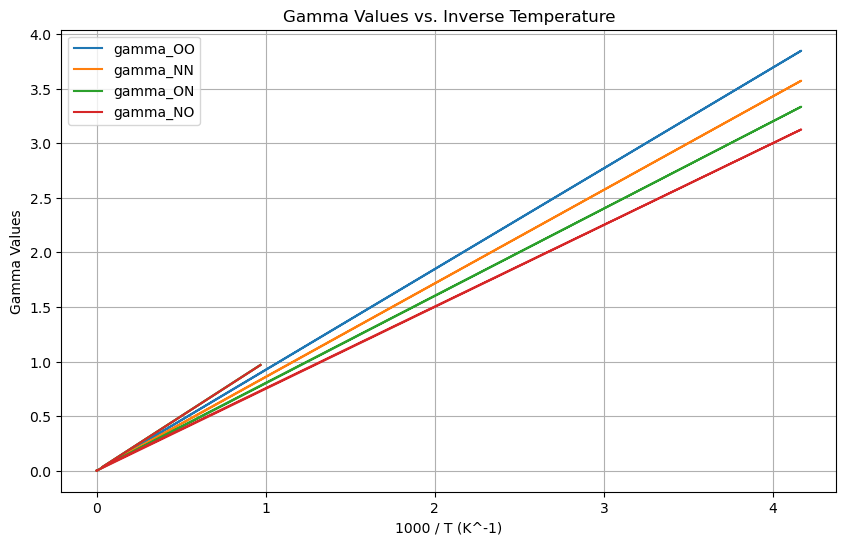

In [13]:
import matplotlib.pyplot as plt

# Assuming the para_cata_project function is already defined and available
ptot = 1100
res = para_cata_project(ptot)

# Extracting the results
theta_O = res[:, 0]
theta_N = res[:, 1]
x = res[:, 2]
gamma_OO = res[:, 3]
gamma_NN = res[:, 4]
gamma_ON = res[:, 5]
gamma_NO = res[:, 6]

# Calculating the inverse temperature x (1000 / T)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, gamma_OO, label='gamma_OO')
plt.plot(x, gamma_NN, label='gamma_NN')
plt.plot(x, gamma_ON, label='gamma_ON')
plt.plot(x, gamma_NO, label='gamma_NO')

plt.xlabel('1000 / T (K^-1)')
plt.ylabel('Gamma Values')
plt.title('Gamma Values vs. Inverse Temperature')
plt.legend()
plt.grid(True)
plt.show()
